# Time Series with ARIMA
In this notebook I will deal with time series using ARIMA with this challenge on Kaggle `https://www.kaggle.com/datasets/rakannimer/air-passengers


Goal:
- Understand whether the series is stationary
- Apply ARIMA using both automatic and manual approaches
- Evaluate model performance
- Introduce SARIMA to model seasonality` 

In [100]:
# General settings and import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10,6

## Load dataset and make some visualization

In [101]:
workdir = print(os.path.abspath(os.curdir))

/home/stefano/Documenti/UNIVERSITA/Magistrale/MachineLearning/Progetto/Spadari-AirPassengers


Make sure to check in which directory you are running, and which is the path of the dataset 

In [102]:
# Set the path of the csv file
path = "AirPassengers.csv"

df = pd.read_csv(path)
df["Month"] = pd.to_datetime(df["Month"])
df = df.set_index("Month")

#Showing the shape of the dataset
df.shape

(144, 1)

Here we plot the data and we can visualize them graphically

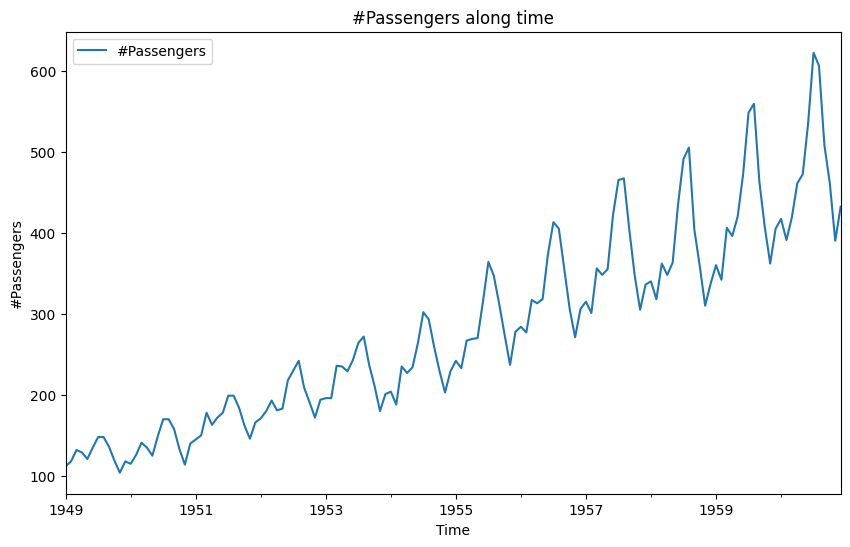

In [103]:
ax = df.plot(title="#Passengers along time", xlabel="Time", ylabel="#Passengers")
plt.show()

Calculating the rolling mean and standard deviation for a window of 12 months

In [104]:
rolmean= df.rolling(window=12).mean().dropna()
rolstd= df.rolling(window=12).std().dropna()
print("Number of NaN row removed:",len(df) - len(rolmean))
print("Number of NaN row removed:",len(df) - len(rolstd))

display(rolmean, rolstd)

Number of NaN row removed: 11
Number of NaN row removed: 11


,#Passengers
Month,
1949-12-01,126.666667
1950-01-01,126.916667
1950-02-01,127.583333
1950-03-01,128.333333
1950-04-01,128.833333
...,...
1960-08-01,463.333333
1960-09-01,467.083333
1960-10-01,471.583333


,#Passengers
Month,
1949-12-01,13.720147
1950-01-01,13.453342
1950-02-01,13.166475
1950-03-01,13.686977
1950-04-01,13.822467
...,...
1960-08-01,83.630500
1960-09-01,84.617276
1960-10-01,82.541954


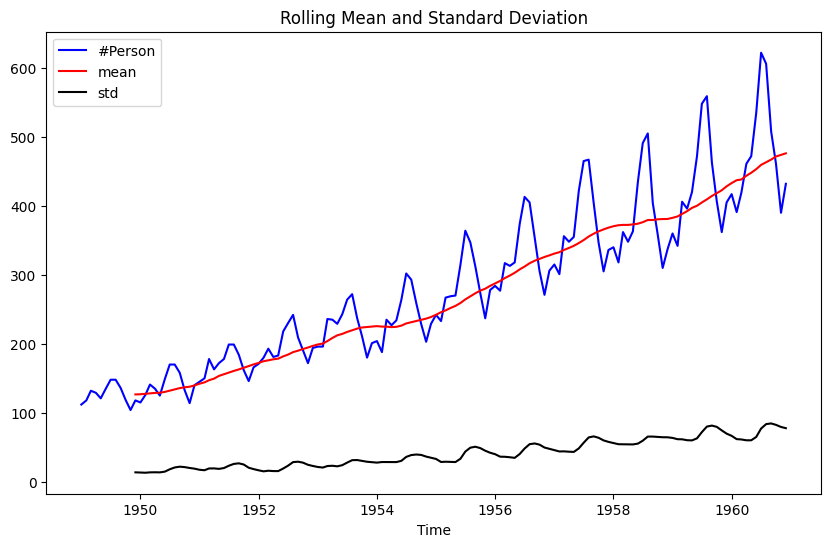

In [105]:
plt.plot(df, color="blue", label="#Person")
plt.plot(rolmean, color="red", label="mean")
plt.plot(rolstd, color="black", label="std")
plt.legend()
plt.title("Rolling Mean and Standard Deviation")
plt.xlabel("Time")
plt.show()


### Stationarity

An ARIMA model assumes the time series is stationary.

A stationary time series has:
- Constant mean over time
- Constant variance over time
- No systematic trend or seasonality

To formally test stationarity we use the Augmented Dickey-Fuller (ADF) test.


In [106]:
print("Result of Dickey Fuller Test:\n")
dftest= adfuller(df["#Passengers"], autolag='AIC')
# display(dftest)

dfoutput= pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observation Used'])
# display(dfoutput)

for key, value in dftest[4].items():
    dfoutput[f'Critical Value ({key})']= value

print(dfoutput)

Result of Dickey Fuller Test:

Test Statistic                  0.815369
p-value                         0.991880
#Lags Used                     13.000000
Number of Observation Used    130.000000
Critical Value (1%)            -3.481682
Critical Value (5%)            -2.884042
Critical Value (10%)           -2.578770
dtype: float64


For a Time Series to be **stationary**, the ADF test must **reject the Null Hypothesis ($H_0$)**:
- **p-value < 0.05**
- **Test Statistic < Critical Value** (the statistic must be *more negative*)

Based on the test results, since the conditions above are not met, it is evident that the series **is non-stationary**.

In [107]:
def test_stationary(df , window = 12):
    mov_avg= df.rolling(window=window).mean()
    mov_std = df.rolling(window=window).std()

    plt.plot(df, color="blue", label="#Person")
    plt.plot(mov_avg, color="red", label="mov_avg")
    plt.plot(mov_std, color="black", label="mov_std")
    plt.title("Moving average and moving std along the time")
    plt.xlabel("Time")
    plt.legend()
    plt.show()

    print("Results of Dickey Fuller Test:\n")
    dftest= adfuller(df)
    dfoutput= pd.Series(dftest[0:4], index=["Test Statistic", "p-value", "#Lags Used", "Number of Observation Used"])
    for key, value in dftest[4].items():
        dfoutput[f'Critical Value ({key})'] = value

    print(dfoutput)
    print(f"\np-value={dfoutput['p-value']}")
    print(f"Difference with critical value:\n{[f"{np.abs(dfoutput['Test Statistic'] - cv):0.3f}" for cv in dfoutput[4:]]}")

This is another function to check the stationarity

In [125]:
def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

## Data Transformation for Stationarity

There are several techniques to transform a non-stationary time series:

- Log transformation (to stabilize variance)
- Differencing (to remove trend)
- Smoothing or moving average subtraction

In this notebook, we focus only on the transformations that make easier to understand and are
directly compatible with the ARIMA framework:

1) Log transformation  
2) First-order differencing


If you want to see more, I would recommend this [`notebook`](https://www.kaggle.com/code/freespirit08/time-series-for-beginners-with-arima/notebook) that shows exponential decay and moving average subtraction, which is the one I've been ispirated.


### Log Scale Trasformation

In the previous plot it's easy to notice that the amplitude of fluctuations increases over time.

Applying a logarithmic transformation:

- Compresses large values
- Stabilizes variance
- Makes the series easier to model

This does NOT remove the trend,
but it improves variance stability.


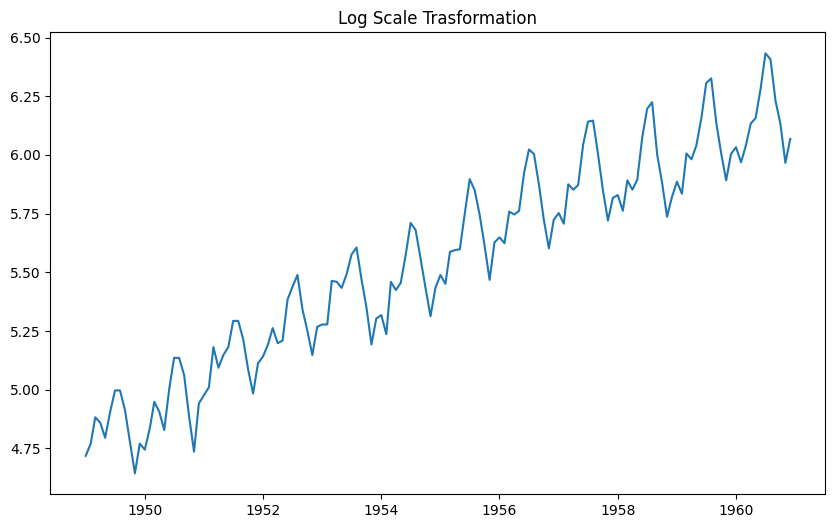

In [108]:
#Log Scale Trasformation

df_logScale= np.log(df)
plt.plot(df_logScale)
plt.title("Log Scale Trasformation")
plt.show()

As you can see the y range is no more 100-600, but 4.75-6.50 and that's help to have a better results in the ADF test, because the differences among data values is smaller.

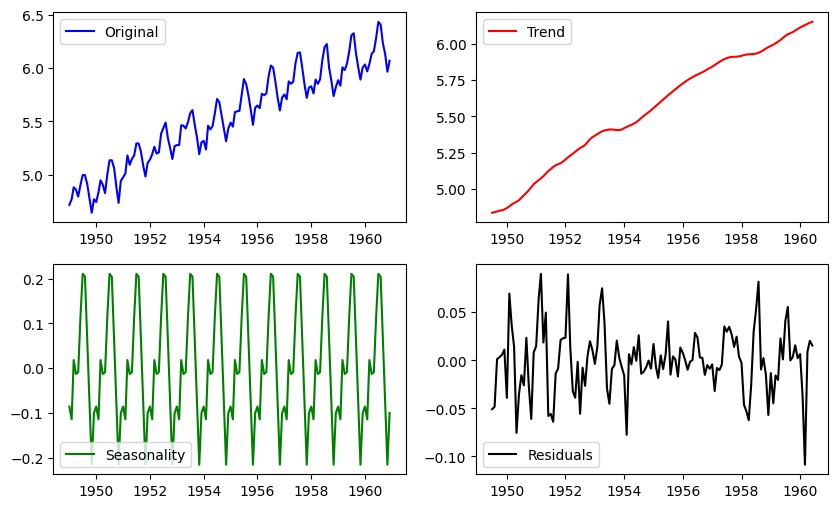

In [109]:
decomposition = seasonal_decompose(df_logScale)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(2,2,1)
plt.plot(df_logScale, color="blue", label='Original')
plt.legend(loc='best')

plt.subplot(2,2,2)
plt.plot(trend, color="red", label='Trend')
plt.legend(loc='best')

plt.subplot(2,2,3)
plt.plot(seasonal, color="green", label='Seasonality')
plt.legend(loc='best')

plt.subplot(2,2,4)
plt.plot(residual, color="black", label='Residuals')
plt.legend(loc='best')
plt.show()

Here it is possible to observe the different components of the ts (trend, seasonality and residuals)

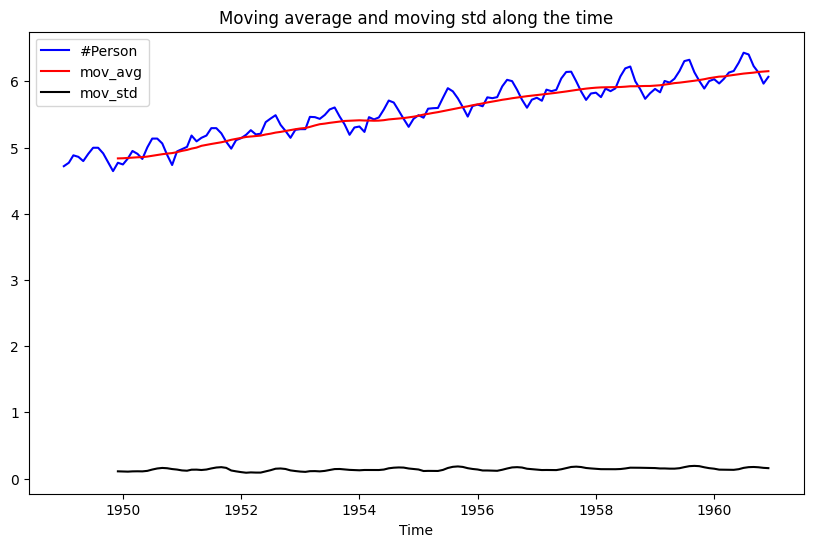

Results of Dickey Fuller Test:

Test Statistic                 -1.717017
p-value                         0.422367
#Lags Used                     13.000000
Number of Observation Used    130.000000
Critical Value (1%)            -3.481682
Critical Value (5%)            -2.884042
Critical Value (10%)           -2.578770
dtype: float64

p-value=0.4223667747703892
Difference with critical value:
['1.765', '1.167', '0.862']


In [110]:
test_stationary(df_logScale, window=12)

p-value is still too high and the statistic is > critical values, so as you can see we havenìt reached stationarity. 


### Time Shift Trasformation
Differencing measures how much the series changes from one time step to the next.

Formally:

y_t' = y_t − y_{t-1}

Instead of modeling absolute values,
we model changes between consecutive observations.

#### ***Just to make an example***

Suppose a shop has the following daily sales:

Day 1: 100  
Day 2: 105  
Day 3: 110  
Day 4: 115  

The series clearly has an upward trend.

If we compute first differences:

(day 2 - day 1) : 105 − 100 = 5  
(day 3 - day 2) : 110 − 105 = 5  
(day 4 - day 3) : 115 − 110 = 5  

The new series becomes:

5, 5, 5

Now the trend disappears.  
We are no longer modeling total sales,
but the daily increase in sales.


#### ***Why does this help?***

A non-stationary series often grows over time,
meaning its mean changes.

After differencing, we focus on variations instead of levels.
If the changes fluctuate around a constant value,
the new series can become stationary.


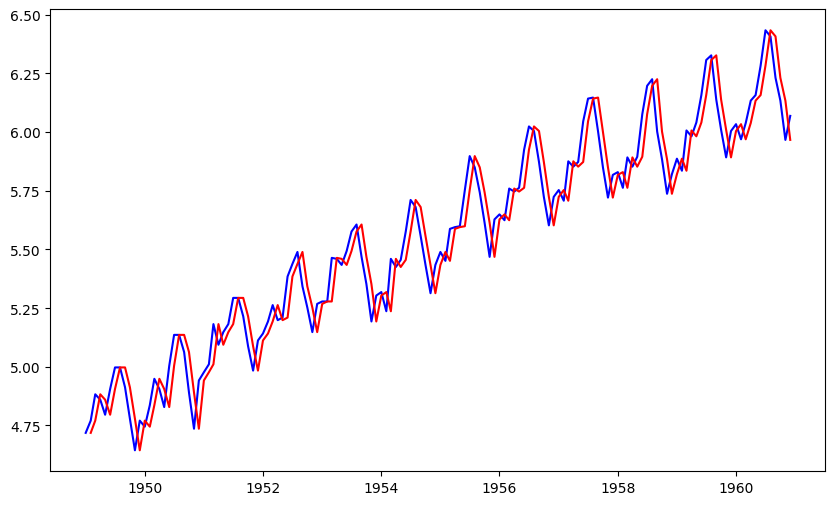

In [111]:
plt.plot(df_logScale, color="blue", label="logaritmic")
plt.plot(df_logScale.shift(), color="red", label="time shifted")

We can see that they have the same trend component.

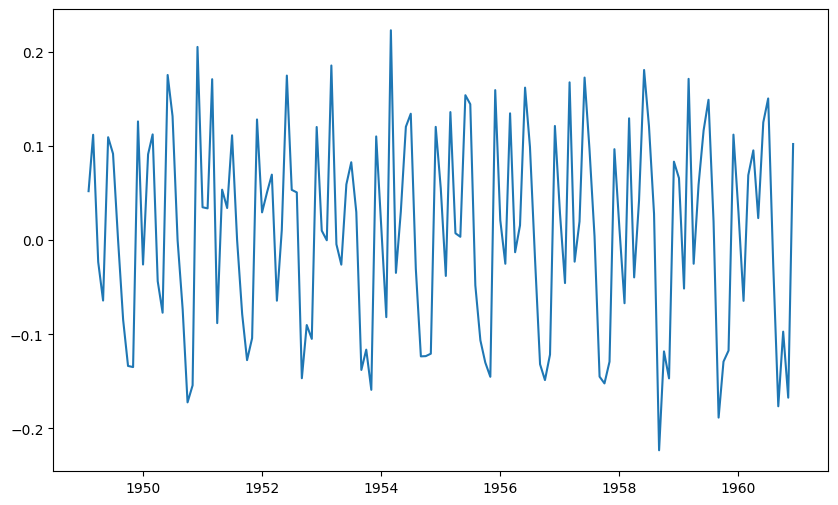

In [112]:
df_trans_ts = df_logScale - df_logScale.shift()
plt.plot(df_trans_ts)

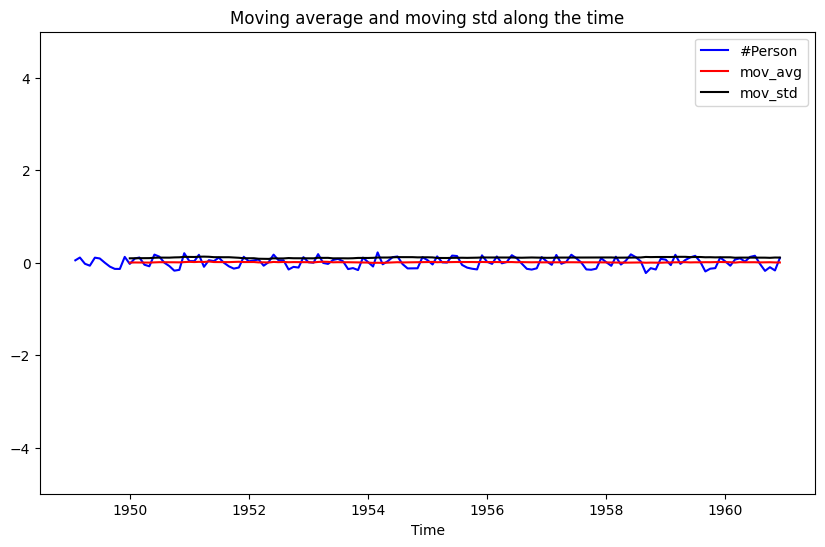

Results of Dickey Fuller Test:

Test Statistic                 -2.717131
p-value                         0.071121
#Lags Used                     14.000000
Number of Observation Used    128.000000
Critical Value (1%)            -3.482501
Critical Value (5%)            -2.884398
Critical Value (10%)           -2.578960
dtype: float64

p-value=0.07112054815085629
Difference with critical value:
['0.765', '0.167', '0.138']


In [113]:
df_trans_ts = df_trans_ts.dropna()
plt.ylim(-5,5)
test_stationary(df_trans_ts)

The ADF test confirms that the log-differenced series is stationary.

The difference order determins the param `d` in ARIMA models:
- we set d = 1

and we will provide the log-transformed series to ARIMA,
letting the model handle the differencing internally.


## Training phase with ARIMA models

We will follow two approaches:

1. automatic approach, which selects parameters for us.
2. manual and analytical approach, where we choose the parameters
   based on ACF and PACF analysis.

This allows us to compare:
- Convenience vs interpretability
- Automation vs understanding

,#Passengers
Month,
1949-01-01,4.718499
1949-02-01,4.770685
1949-03-01,4.882802
1949-04-01,4.859812
1949-05-01,4.795791
...,...
1958-08-01,6.224558
1958-09-01,6.001415
1958-10-01,5.883322


,#Passengers
Month,
1959-01-01,5.886104
1959-02-01,5.834811
1959-03-01,6.006353
1959-04-01,5.981414
1959-05-01,6.040255
1959-06-01,6.156979
1959-07-01,6.306275
1959-08-01,6.326149
1959-09-01,6.137727


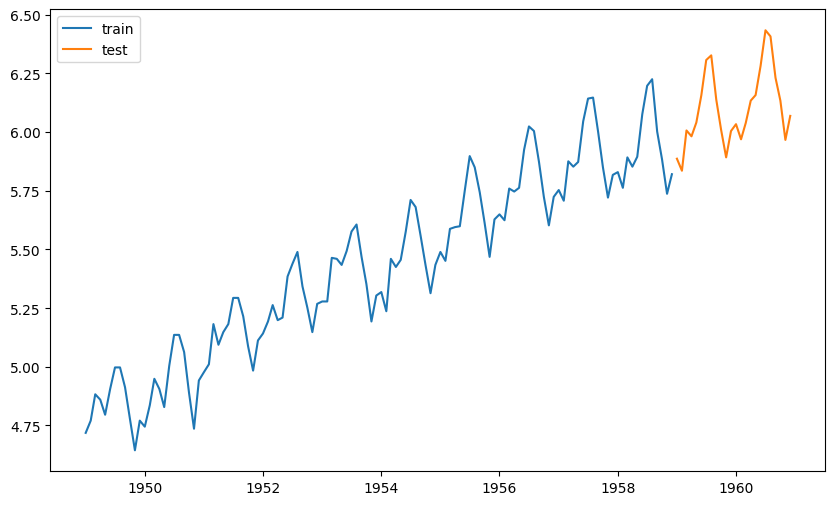

In [114]:
# PREPARING TRAIN AND TEST SET
#This code is because I didn't want to split train and test in the middle of a year.
years = len(df_logScale.index.year.unique())  #to evaluate how many years in the dataset
train_percent=0.9   #to set the train percent desired
train_size= int(years*train_percent) *12    #to extract the train percentage years
train, test = df_logScale[0:train_size], df_logScale[train_size:]

display(train, test)
plt.plot(train, label="train")
plt.plot(test, label="test")
plt.legend()   
plt.show()

### Automatic
We start with an automatic ARIMA selection.  
The advantage of this approach is simplicity:
we do not need to manually inspect ACF or PACF plots.  
The algorithm searches across combinations of (p, d, q)
and selects the model that optimizes an information criterion (AIC).

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.96 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-193.784, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-195.846, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-197.533, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-194.869, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-200.484, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-197.689, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-201.680, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-198.889, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-197.184, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-208.368, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-198.771, T

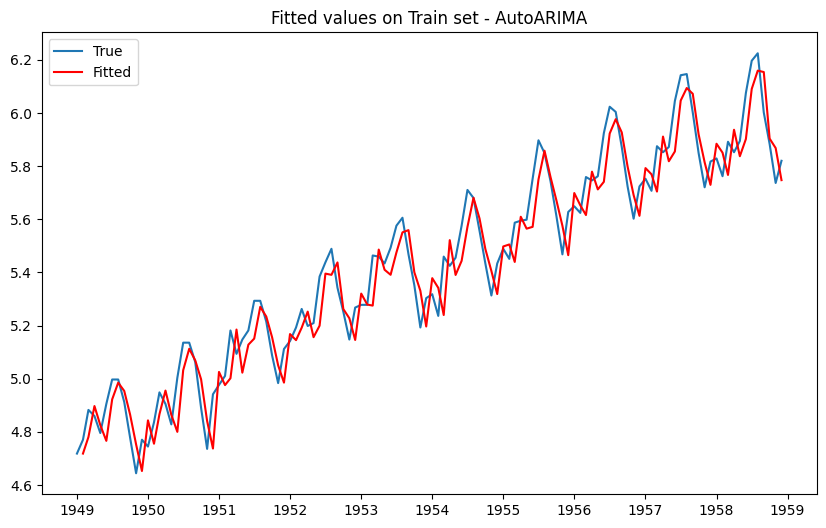

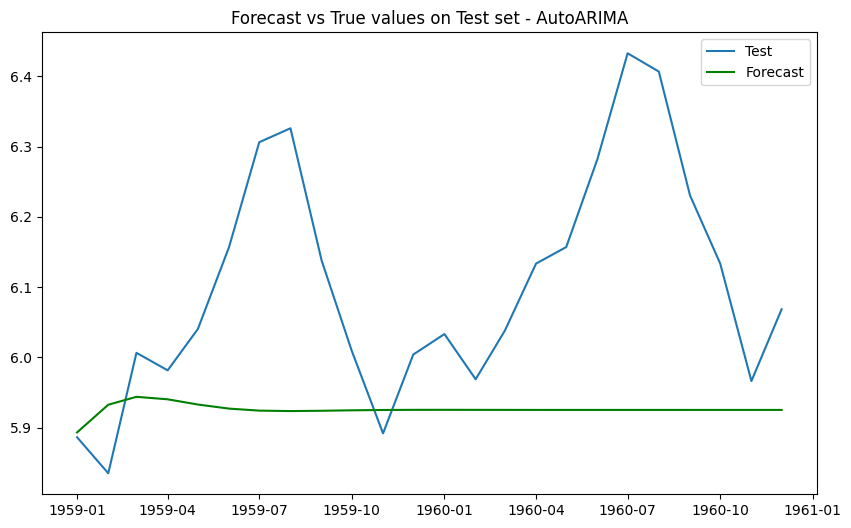

RSS: 1.35


In [115]:
from pmdarima.arima import AutoARIMA, auto_arima
import warnings
warnings.filterwarnings("ignore", message=".*'force_all_finite' was renamed to 'ensure_all_finite'.*")


autoArima = AutoARIMA(trace=True)
autoArima.fit(train)
autoArima.summary()

fitted_values_autoARIMA = autoArima.model_.fittedvalues()

forecast_autoARIMA = autoArima.predict(n_periods=len(test))
forecast_autoARIMA.index = test.index

plt.title("Fitted values on Train set - AutoARIMA")
plt.plot(train, label="True")
plt.plot(fitted_values_autoARIMA[1:], c="r", label="Fitted")
plt.legend()
plt.show()

plt.title("Forecast vs True values on Test set - AutoARIMA")
plt.plot(test, label="Test")
plt.plot(forecast_autoARIMA, c="g", label="Forecast")
plt.legend()
plt.show()

RSS_autoARIMA = ((forecast_autoARIMA - test["#Passengers"])**2).sum()
print(f"RSS: {RSS_autoARIMA:.2f}")

### Manually

Although the automatic approach is convenient,
it does not necessarily guarantee the best model.

We now try a more analytical strategy.

Using ACF and PACF plots,
we manually identify plausible values for:

- p (autoregressive order)
- q (moving average order)

This approach requires more effort,
but it allows us to better understand the underlying structure of the data.


#### What are `ACF` and `PACF` ????

**ACF** stands for Auto Correlation Function, and shows how much a data measured in a certain *t*, can be influenced by the previous ones.
- Why a data can be influenced by the previous ones?
    If we make an example, we can think that maybe if you spent a great amount of money now, it will influences the money spent in the next days, weeks, months and years.
    So a big amount of money spent today could influence money sent in the future, and with autocorrelation function we are interest in seeing how much the money spent today, could be influenced by the mone spent 1d before, 2d before, 3d before,......

But ACF can measure the correlation in two way: directly and indirectly. 
- directly: this is the correlation on how much a data from the past influence on today.
- indirectly: here there is the information about how much this data influences the next one, that influence the next one, till we reach the current instant.

We can say that a data measured in a certain *t*, can have a direct effect on the current data, or an indirect link that means all the links from that *t* to all the consecutive *t* among the current one.

Here we can explain *what is **PACF***:
PACF is Partial Auto Correlation Function, and its aim is to provide only the "direct link", not all the indirect ones.

What this two indicator says to us?
- ACF: it contains many factor in it. A certain istant could be so correlated with an other, because of all of those consecutive links.
- PACF: It allows us to see only how much a past data is correlated with the current ones. It deletes all that indirect effect.



#### Plotting `ACF` and `PACF` to get `q` and `p` (Manually)
At first, we need to discover the parameters p and q, so we will proceed with the plot of AFC and PACF.

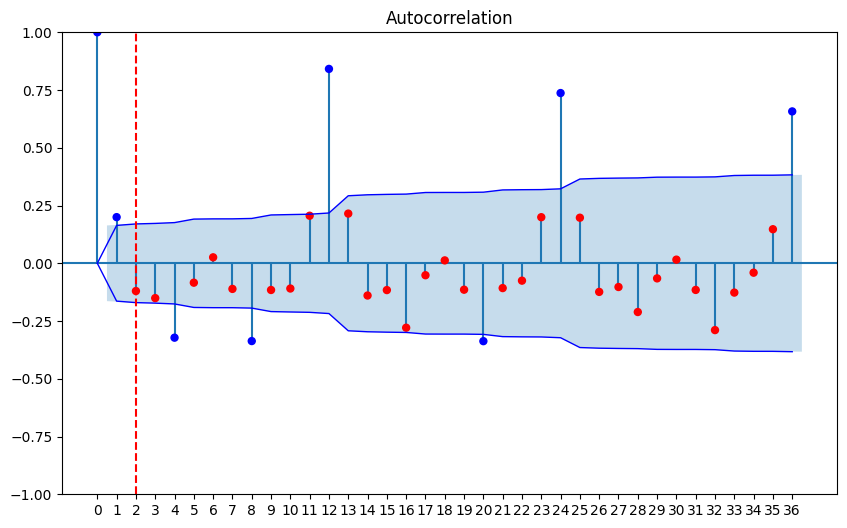

,#lag,-conf,ACF,conf
0,0.0,-0.000000,1.000000,0.000000
1,1.0,-0.163903,0.199751,0.163903
2,2.0,-0.170318,-0.120104,0.170318


First non-significant ACF lag: q = 1




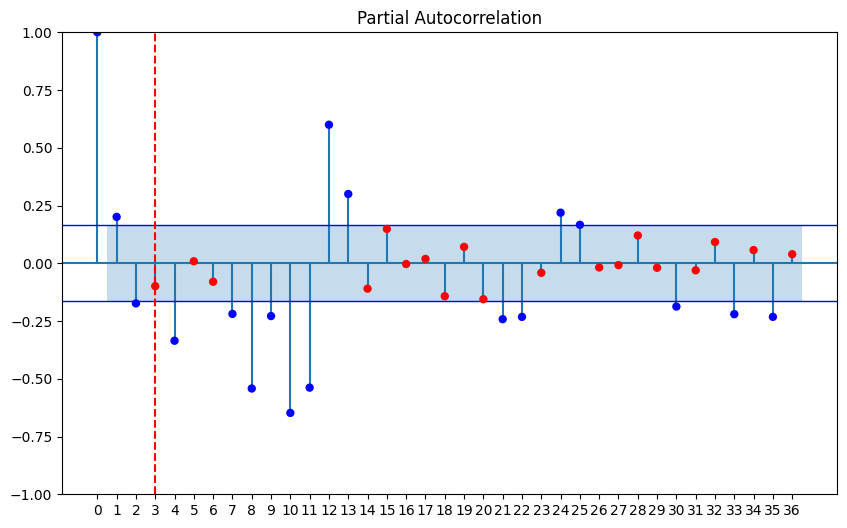

,#lag,-conf,PACF,conf
0,0.0,-0.163903,1.000000,0.163903
1,1.0,-0.163903,0.200815,0.163903
2,2.0,-0.163903,-0.173682,0.163903
3,3.0,-0.163903,-0.099012,0.163903


First non-significant PACF lag: p = 2


In [116]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Parameters
nlags = 36
N = len(df_trans_ts)
z = 1.96  # 95% confidence level


# ==========================================================
# ACF
# ==========================================================
acf_vals = acf(df_trans_ts, nlags=nlags)

# Compute Bartlett confidence intervals (centered at 0)
acf_conf = np.zeros(nlags+1)
for k in range(1, nlags+1):
    acf_conf[k] = z * np.sqrt((1 + 2 * np.sum(acf_vals[1:k]**2)) / N)
    # Each lag’s variance increases with the cumulative sum of squared previous ACFs

# Determine colors: red if inside confidence band, blue if outside
# - red if within confidence band (non-significant)
# - blue if outside confidence band (significant autocorrelation)
acf_colors = np.where((acf_vals > acf_conf) | (acf_vals < -acf_conf), 'blue', 'red')

# Build a table with ACF values and confidence limits for reference
acf_df = pd.DataFrame(columns=["#lag","-conf", "ACF", "conf"])
for i, v in enumerate(acf_vals):
    acf_df.loc[len(acf_df)]= [i, -acf_conf[i],v,acf_conf[i]]
    # Find the first lag where ACF falls within the confidence band
    if -acf_conf[i] <= v <= acf_conf[i]:
        q = i-1
        break

# Plot ACF with colored points and vertical line at first non-significant lag
plot_acf(df_trans_ts, lags=nlags, marker=None)  # marker=None hides default blue markers from plot_acf
# Manually plot scatter points with our custom colors and size
plt.scatter(range(nlags + 1), acf_vals, c=acf_colors, zorder=2,  # zorder keeps points above lines
            s=(rcParams['lines.markersize'] / 1.2) ** 2)         # s = marker size
plt.plot(acf_conf, c="b", lw=1)
plt.plot(-acf_conf, c="b", lw=1)
plt.xticks(range(nlags+1)) # show tick labels for each lag from 0 to nlags
plt.axvline(q+1, c="r", label="q", linestyle="--")    # Vertical line for first non-significant lag
plt.show()

display(acf_df)
print(f"First non-significant ACF lag: q = {q}\n\n")


# ==========================================================
# PACF
# ==========================================================
pacf_vals = pacf(df_trans_ts, nlags=nlags, method="ols")

# PACF confidence band (constant across lags, unlike ACF Bartlett bounds)
pacf_conf = z / np.sqrt(N)

# Determine colors: red if inside confidence band, blue if outside
pacf_colors = np.where((pacf_vals > pacf_conf) | (pacf_vals < -pacf_conf), 'blue', 'red')

# Find the first lag where PACF falls within the confidence band
pacf_df = pd.DataFrame(columns=["#lag", "-conf", "PACF", "conf"])
for i, v in enumerate(pacf_vals):
    pacf_df.loc[len(pacf_df)]= [i, -pacf_conf,v,pacf_conf]
    if -pacf_conf <= v <= pacf_conf:
        p = i-1
        break

# Plot PACF with colored points and vertical line at first non-significant lag
plot_pacf(df_trans_ts, lags=nlags, marker=None, method='ols')
plt.xticks(range(nlags+1))  # show tick labels for each lag
plt.axhline(pacf_conf, c="b", lw=1)
plt.axhline(-pacf_conf, c="b", lw=1)
plt.axvline(p+1, c="r", label="p", linestyle="--")
plt.scatter(range(nlags+1), pacf_vals, c=pacf_colors, zorder=2, s=(rcParams['lines.markersize']/1.2) ** 2)
plt.show()
20
display(pacf_df)
print(f"First non-significant PACF lag: p = {p}")



### Models build
Even if we are using ARIMA, we will try first only AR and MA to see the difference and to make some evaluation.

#### AR Model

/home/stefano/Documenti/UNIVERSITA/Magistrale/MachineLearning/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/stefano/Documenti/UNIVERSITA/Magistrale/MachineLearning/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/stefano/Documenti/UNIVERSITA/Magistrale/MachineLearning/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


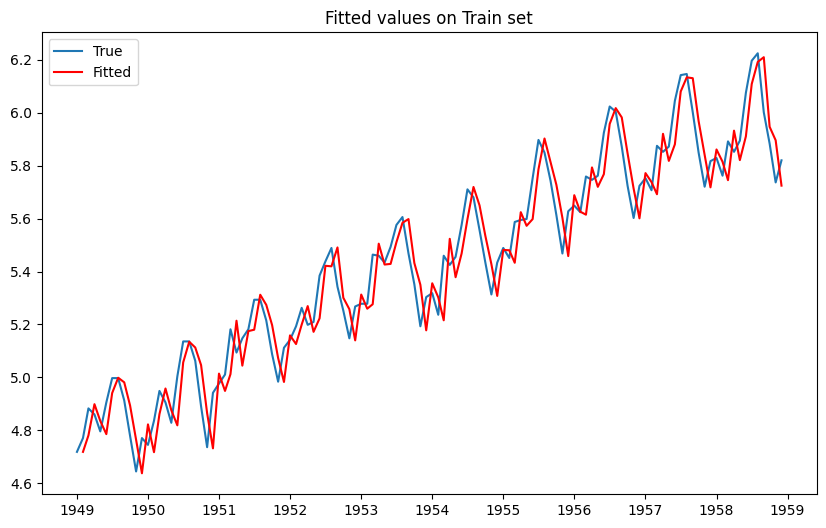

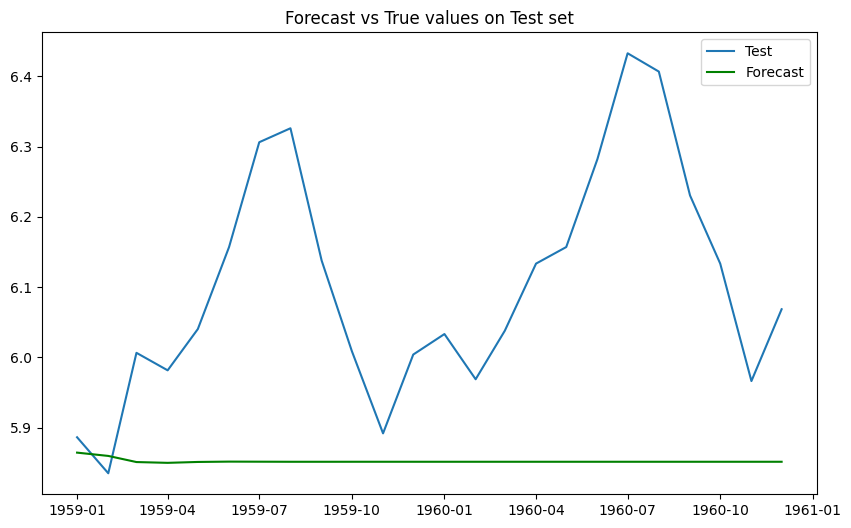

RSS: 2.11


In [117]:
ar = ARIMA(train, order=(p,1,0))
results_AR = ar.fit()

fitted_values_AR = results_AR.fittedvalues

# Forecast for the test set
forecast_AR = results_AR.forecast(steps=len(test))
forecast_AR.index = test.index  # align index for plotting and RSS

plt.title("Fitted values on Train set")
plt.plot(train, label="True")
plt.plot(fitted_values_AR[1:], c="r", label="Fitted")
plt.legend()
plt.show()

plt.title("Forecast vs True values on Test set")
plt.plot(test, label="Test")
plt.plot(forecast_AR, c="g", label="Forecast")
plt.legend()
plt.show()

RSS_ar = ((forecast_AR - test["#Passengers"])**2).sum()
print(f"RSS: {RSS_ar:.2f}")

#### MA Model

/home/stefano/Documenti/UNIVERSITA/Magistrale/MachineLearning/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/stefano/Documenti/UNIVERSITA/Magistrale/MachineLearning/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/stefano/Documenti/UNIVERSITA/Magistrale/MachineLearning/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


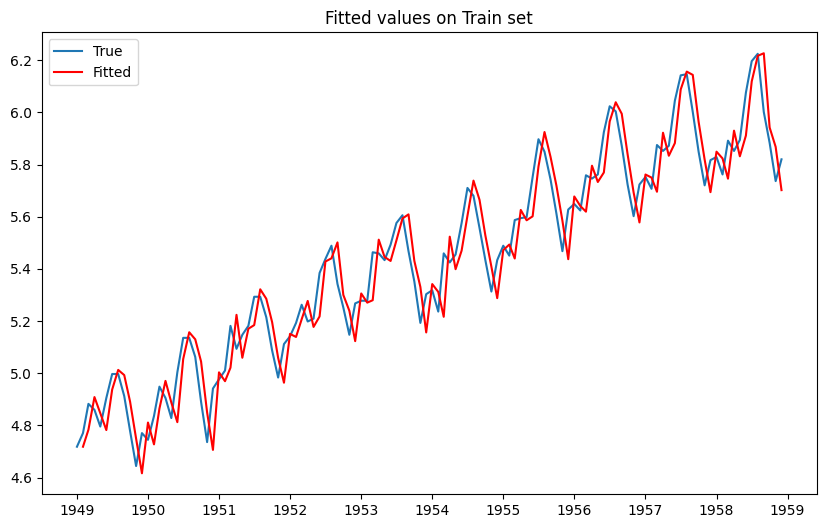

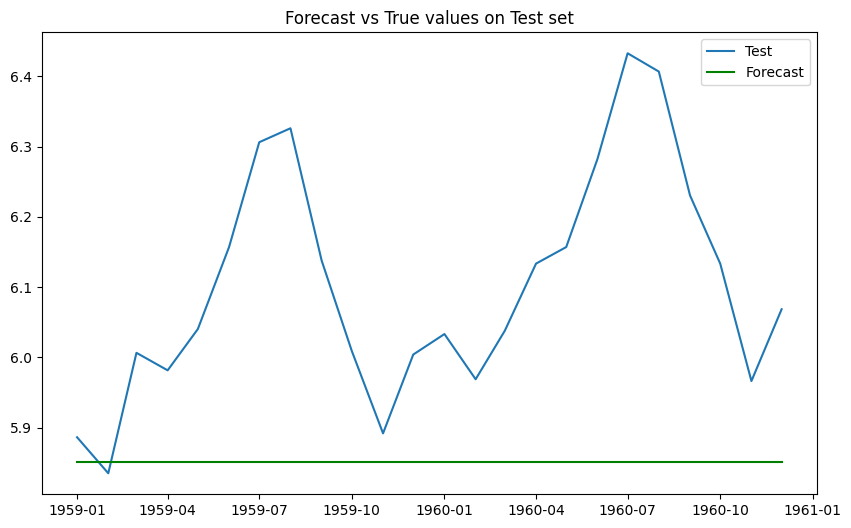

RSS: 2.11


In [118]:
ma = ARIMA(train, order=(0,1,q))
results_MA= ma.fit()

fitted_values_MA = results_MA.fittedvalues

# Forecast for the test set
forecast_MA  = results_MA.forecast(steps=len(test))
forecast_MA.index = test.index  # align index for plotting and RSS

plt.title("Fitted values on Train set")
plt.plot(train, label="True")
plt.plot(fitted_values_MA[1:], c="r", label="Fitted")
plt.legend()
plt.show()

plt.title("Forecast vs True values on Test set")
plt.plot(test, label="Test")
plt.plot(forecast_MA, c="g", label="Forecast")
plt.legend()
plt.show()

RSS_ma = ((forecast_MA - test["#Passengers"])**2).sum()
print(f"RSS: {RSS_ma:.2f}")

#### ARIMA
After using AR and MA now we will use ARIMA.

/home/stefano/Documenti/UNIVERSITA/Magistrale/MachineLearning/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/stefano/Documenti/UNIVERSITA/Magistrale/MachineLearning/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/stefano/Documenti/UNIVERSITA/Magistrale/MachineLearning/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


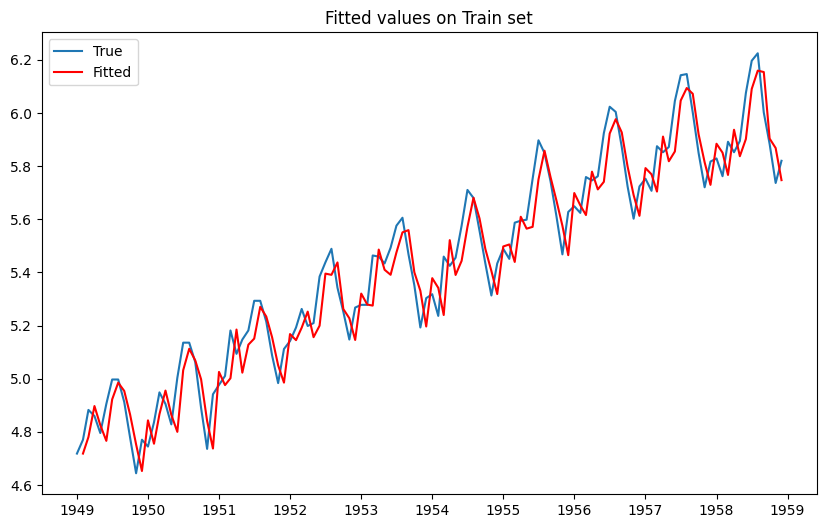

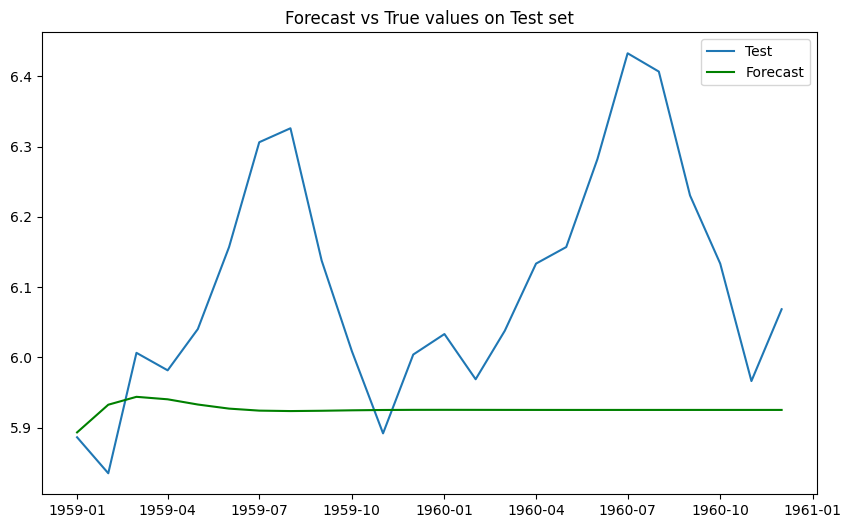

RSS: 1.35


In [119]:
arima = ARIMA(train, order=(p,1,q))
results_ARIMA= arima.fit()

fitted_values_ARIMA = results_ARIMA.fittedvalues

# Forecast for the test set
forecast_ARIMA  = results_ARIMA.forecast(steps=len(test))
forecast_ARIMA.index = test.index  # align index for plotting and RSS

plt.title("Fitted values on Train set")
plt.plot(train, label="True")
plt.plot(fitted_values_ARIMA[1:], c="r", label="Fitted")
plt.legend()
plt.show()

plt.title("Forecast vs True values on Test set")
plt.plot(test, label="Test")
plt.plot(forecast_ARIMA, c="g", label="Forecast")
plt.legend()
plt.show()

RSS_arima = ((forecast_ARIMA - test["#Passengers"])**2).sum()
print(f"RSS: {RSS_arima:.2f}")

### ARIMA Performance Analysis

- The automatic and manual ARIMA models produce very similar parameters.
- AR and MA alone perform worse than the combined ARIMA model.
- However, even the best ARIMA model struggles to capture the repeating yearly peaks.

This suggests that the series contains a strong seasonal component
that cannot be modeled by a non-seasonal ARIMA structure.


### SARIMA

There is still another pattern that ARima can't capture, and it is **seasonality**.
So the last model that I want to try is **SARIMA**.

Best parameters are p=2, q=1 and P=1, Q=1, s=12

/home/stefano/Documenti/UNIVERSITA/Magistrale/MachineLearning/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/stefano/Documenti/UNIVERSITA/Magistrale/MachineLearning/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/stefano/Documenti/UNIVERSITA/Magistrale/MachineLearning/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


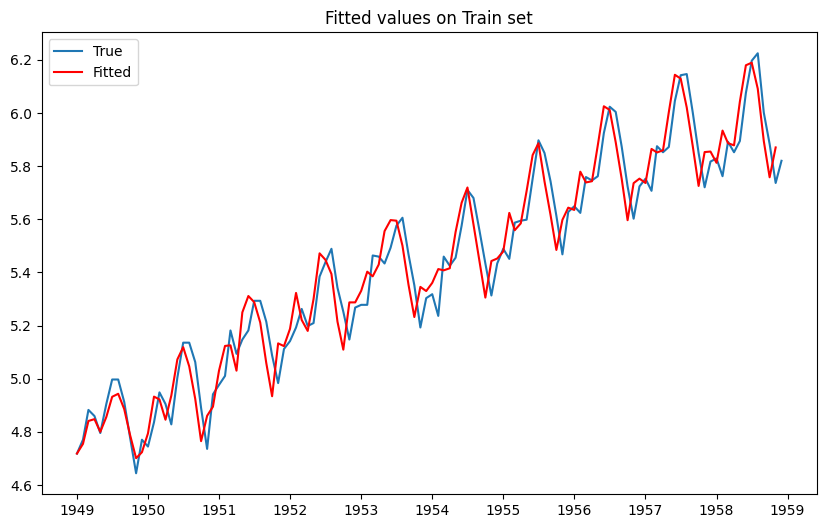

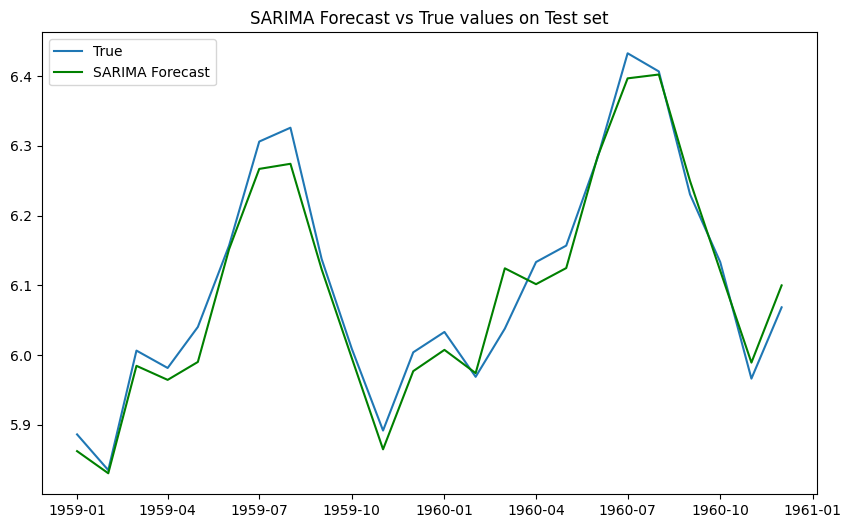

RSS: 0.02


In [120]:
s=12
sarima = SARIMAX(train, order=(p,1,q), seasonal_order=(1,0,1,s))
results_SARIMA= sarima.fit()

fitted_values_SARIMA = results_SARIMA.fittedvalues.shift(-1)

forecast_SARIMA= results_SARIMA.forecast(steps=len(test))
forecast_SARIMA.index = test.index

plt.title("Fitted values on Train set")
plt.plot(train, label="True")
plt.plot(fitted_values_SARIMA, c="r", label="Fitted")
plt.legend()
plt.show()

plt.plot(test, label="True")
plt.plot(forecast_SARIMA, label="SARIMA Forecast", c="g")
plt.title("SARIMA Forecast vs True values on Test set")
plt.legend()
plt.show()

RSS_sarima = ((forecast_SARIMA - test["#Passengers"])**2).sum()
print(f"RSS: {RSS_sarima:.2f}")

### Comparison Between Models
So we tried different models, as autoARIMA for the automatic approach and AR, MA, ARIMA and SARIMA for the manual approach.

Here we need to compare all the models forecast.

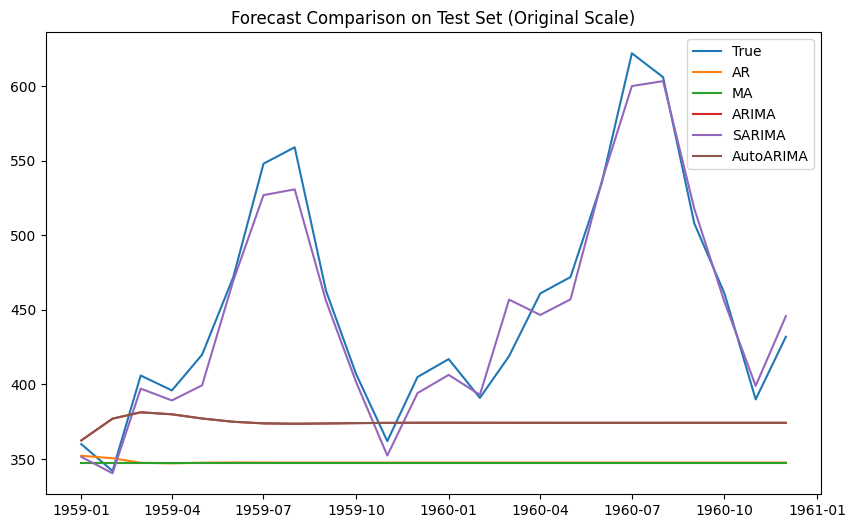

In [121]:
trues_exp = np.exp(test)
forecast_AR_exp = np.exp(forecast_AR)
forecast_MA_exp = np.exp(forecast_MA)
forecast_ARIMA_exp = np.exp(forecast_ARIMA)
forecast_SARIMA_exp = np.exp(forecast_SARIMA)
forecast_autoARIMA_exp = np.exp(forecast_autoARIMA)

plt.plot(trues_exp, label="True")
plt.plot(forecast_AR_exp, label="AR")
plt.plot(forecast_MA_exp, label="MA")
plt.plot(forecast_ARIMA_exp, label="ARIMA")
plt.plot(forecast_SARIMA_exp, label="SARIMA")
plt.plot(forecast_autoARIMA_exp, label="AutoARIMA")
plt.title("Forecast Comparison on Test Set (Original Scale)")
plt.legend()
plt.show()


AR: 396410.88
MA: 396484.72
ARIMA: 279132.51
SARIMA: 5027.60
AutoARIMA: 279132.51


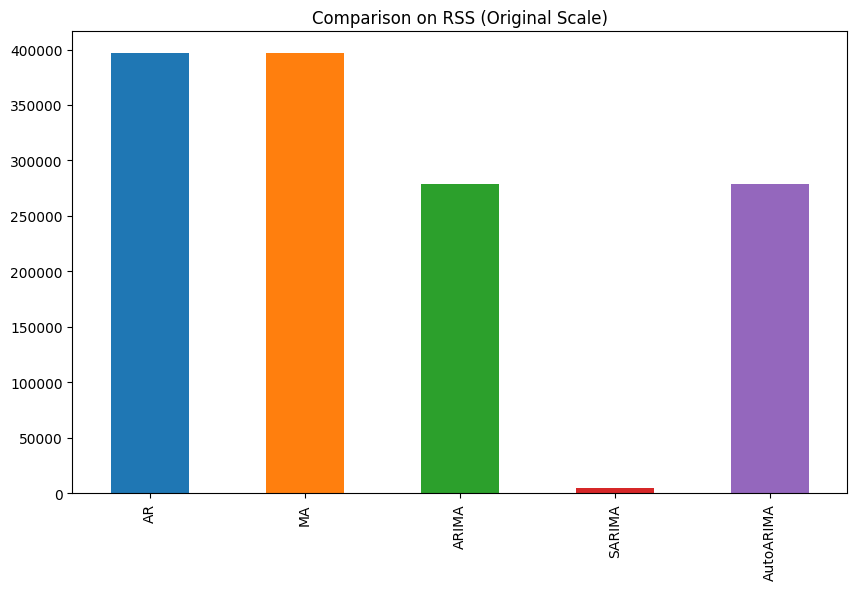

In [122]:
RSS_AR = ((forecast_AR_exp - trues_exp["#Passengers"])**2).sum()
print(f"AR: {RSS_AR:.2f}")

RSS_MA = ((forecast_MA_exp - trues_exp["#Passengers"])**2).sum()
print(f"MA: {RSS_MA:.2f}")

RSS_ARIMA = ((forecast_ARIMA_exp - trues_exp["#Passengers"])**2).sum()
print(f"ARIMA: {RSS_ARIMA:.2f}")

RSS_SARIMA = ((forecast_SARIMA_exp - trues_exp["#Passengers"])**2).sum()
print(f"SARIMA: {RSS_SARIMA:.2f}")

RSS_autoARIMA = ((forecast_autoARIMA_exp - trues_exp["#Passengers"])**2).sum()
print(f"AutoARIMA: {RSS_autoARIMA:.2f}")

results_df = pd.DataFrame(columns=["AR", "MA", "ARIMA", "SARIMA", "AutoARIMA"])
results_df.loc['RSS'] = [RSS_AR, RSS_MA, RSS_ARIMA, RSS_SARIMA, RSS_autoARIMA]
results_df.loc["RSS"].plot(kind="bar", color=sns.color_palette())
plt.title("Comparison on RSS (Original Scale)")
plt.show()


## Model Evaluation 

To compare the models, we need quantitative metrics.

Since this is a forecasting problem, we evaluate performance
on the **test set only**, using error-based metrics.

We will consider:

- RMSE (Root Mean Squared Error)
- MAE (Mean Absolute Error)
- MAPE (Mean Absolute Percentage Error)

Each metric highlights a different aspect of prediction quality.


In [123]:
from sklearn.metrics import mean_absolute_percentage_error, root_mean_squared_error, mean_absolute_error

RMSE_AR = root_mean_squared_error(trues_exp, forecast_AR_exp)
RMSE_MA = root_mean_squared_error(trues_exp, forecast_MA_exp)
RMSE_ARIMA = root_mean_squared_error(trues_exp, forecast_ARIMA_exp)
RMSE_SARIMA = root_mean_squared_error(trues_exp, forecast_SARIMA_exp)
RMSE_autoARIMA = root_mean_squared_error(trues_exp, forecast_autoARIMA_exp)

MAE_AR = mean_absolute_error(trues_exp, forecast_AR_exp)
MAE_MA = mean_absolute_error(trues_exp, forecast_MA_exp)
MAE_ARIMA = mean_absolute_error(trues_exp, forecast_ARIMA_exp)
MAE_SARIMA = mean_absolute_error(trues_exp, forecast_SARIMA_exp)
MAE_autoARIMA = mean_absolute_error(trues_exp, forecast_autoARIMA_exp)

MAPE_AR = mean_absolute_percentage_error(trues_exp, forecast_AR_exp)
MAPE_MA = mean_absolute_percentage_error(trues_exp, forecast_MA_exp)
MAPE_ARIMA = mean_absolute_percentage_error(trues_exp, forecast_ARIMA_exp)
MAPE_SARIMA = mean_absolute_percentage_error(trues_exp, forecast_SARIMA_exp)
MAPE_autoARIMA = mean_absolute_percentage_error(trues_exp, forecast_autoARIMA_exp)


metrics = pd.DataFrame({
    "Model": ["AR", "MA", "ARIMA", "SARIMA", "AutoARIMA"],
    "RMSE": [RMSE_AR, RMSE_MA, RMSE_ARIMA, RMSE_SARIMA, RMSE_autoARIMA],
    "MAE": [MAE_AR, MAE_MA, MAE_ARIMA, MAE_SARIMA, MAE_autoARIMA],
    # multiply by 100 to convert to percentage
    "MAPE (%)": [MAPE_AR*100, MAPE_MA*100, MAPE_ARIMA*100, MAPE_SARIMA*100, MAPE_autoARIMA*100],
})
metrics.set_index("Model", inplace=True)

# Arrotonda a 2 decimali per una lettura più pulita
metrics = metrics.round(2)

metrics.sort_values("RMSE", inplace=True)
metrics

,RMSE,MAE,MAPE (%)
Model,,,
SARIMA,14.47,11.43,2.51
ARIMA,107.84,81.87,16.26
AutoARIMA,107.84,81.87,16.26
AR,128.52,105.03,21.29
MA,128.53,105.08,21.30


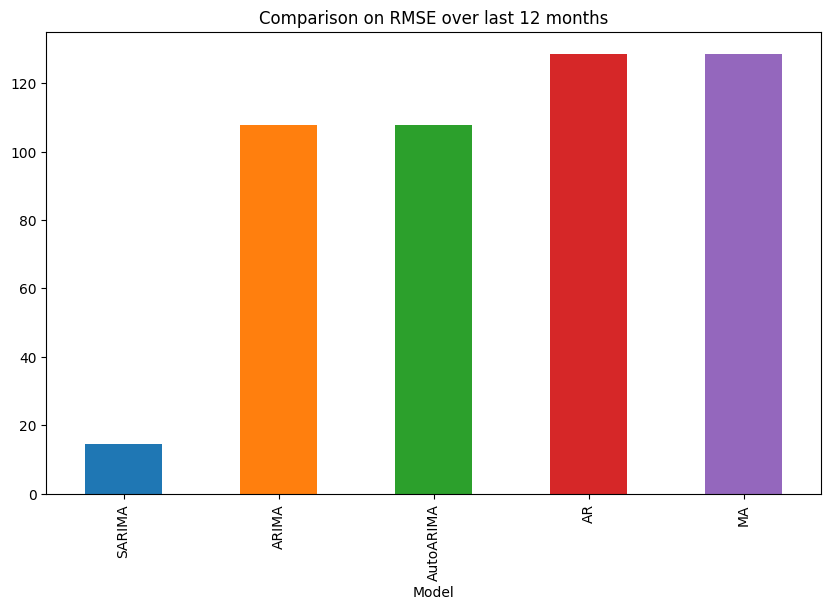

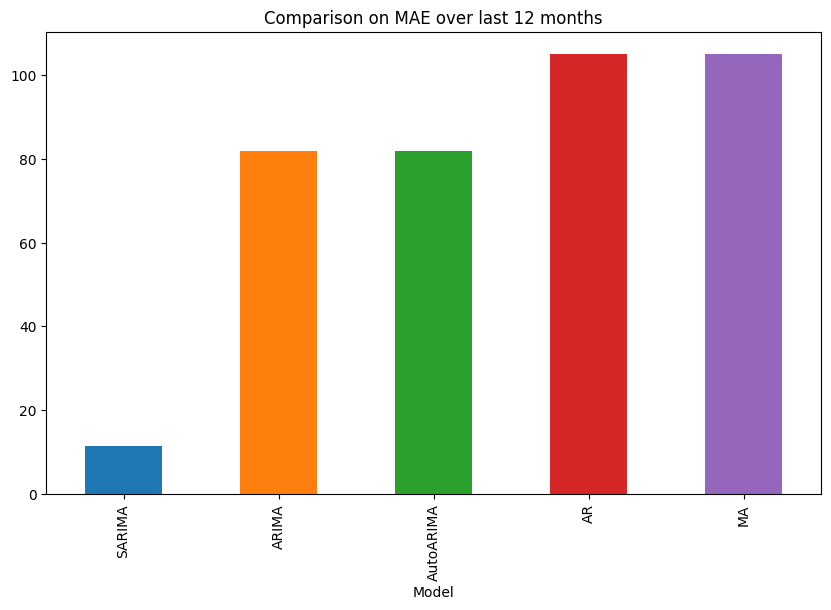

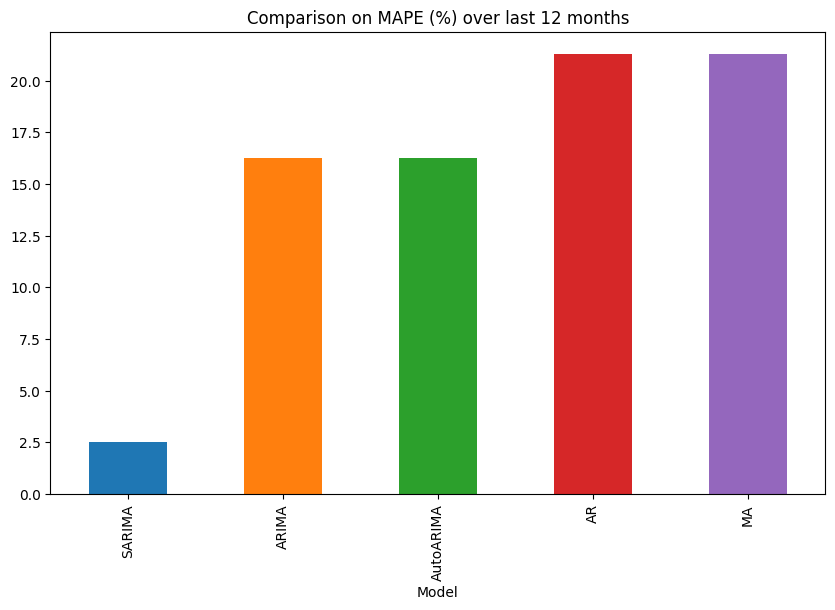

In [124]:
for entry in metrics.sort_values("RMSE", ascending=False):
    metrics[entry].plot(kind="bar", color=sns.color_palette())
    plt.title(f"Comparison on {entry} over last 12 months")
    plt.show()

## Conclusion

As a conclusion we can see that even all the ARIMA models, don't work very well, because they can't catch the seasonal component.  
Non-seasonal ARIMA models are able to capture short-term autoregressive and moving average dynamics, but they fail to reproduce the strong yearly seasonal pattern.

While with Seasonal ARIMA (SARIMA) we manage to catch the seasonality and to make a closer prediction to the true values, so it seems that it is the best and only one that can be considered valide.